# Morpheus

In this notebook we show how to interface [pyABC](https://github.com/icb-dcm/pyabc) with the [Morpheus](https://morpheus.gitlab.io/) toolbox.

In [1]:
import pyabc
import pyabc.external
import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


A Morpheus model is created by passing a Morpheus XML file to the ``pyabc.external.MorpheusModel`` class. Here wew need to specify the mapping of parameters to xpaths in the model file, to tell pyABC where to put parameters in the model.

In [2]:
file_ = "/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml"
par_map = {'V1': './CellTypes/CellType/System/Constant[@symbol="V1"]',
           'V2': './CellTypes/CellType/System/Constant[@symbol="V2"]',
           'k3': './CellTypes/CellType/System/Constant[@symbol="k3"]'}
model = pyabc.external.MorpheusModel(file_, par_map=par_map, output=pyabc.external.morpheus.output_dict)

print(model)

MorpheusModel {
	exec_name:	morpheus
	model_file:	/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml
	name:	/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml
	output:	output_dict
}


Let us generate some dummy observed data. Therefore, we sample from true parameters. The returned value contains a link to a folder which has been newly created to accommodate all simulation files. By default, that folder is in the system's temporary folders, but that can also be customized.

The paramters we define here must correspond to Constants in the Morpheus XML file.

In [3]:
true_pars = {'V1': 2.7, 'V2': 0.25, 'k3': 0.025}
limits = {key: (0.5 * val, 2 * val) for key, val in true_pars.items()}

# generate data
observed_data = model.sample(true_pars)

Here, we specified the output to be a dictionary object. The output format can also be customized. Let us see what we obtain:

In [4]:
print(pd.DataFrame(observed_data))

       time  cell.id        MAPK     MAPK_P     MAPK_PP         MKK  \
0     0.000        1  280.000000  10.000000   10.000000  280.000000   
1     0.001        1  279.897383  10.501547    9.601070  280.079672   
2     0.002        1  279.869891  10.921726    9.208383  279.820434   
3     0.003        1  279.891635  11.279308    8.829057  279.225075   
4     0.004        1  279.937855  11.591113    8.471032  278.294260   
5     0.005        1  279.984682  11.872654    8.142664  277.027466   
6     0.006        1  280.008944  12.138570    7.852486  275.423680   
7     0.007        1  279.987987  12.402910    7.609103  273.481998   
8     0.008        1  279.899517  12.679300    7.421183  271.202187   
9     0.009        1  279.721458  12.981008    7.297535  268.585234   
10    0.010        1  279.431854  13.320915    7.247231  265.633882   
11    0.011        1  279.008818  13.711404    7.279778  262.353135   
12    0.012        1  278.430536  14.164173    7.405291  258.750706   
13    

As usual, we have to define a prior for our parameters. Also, we have to define a distance which computes a 1-dim value from the generated data. Note that also this step can be customized, e.g. for arbitrary summary statistics.

In [5]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

def distance(val1, val2):
    d = np.sum([np.sum(np.abs(val1[key] - val2[key])) \
                for key in ['MAPK_P', 'MKK_P']])
    return d

Now, we are able to run our ABC analysis as usual. The ``pyabc.external`` classes take care of all calls to the external simulator.

In [6]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, observed_data)

INFO:History:Start <ABCSMC(id=1, start_time=2019-06-20 07:48:45.086055, end_time=None)>


In [7]:
abc.run(max_nr_populations=4)

INFO:Epsilon:initial epsilon is 75099.22632298752
INFO:ABC:t:0 eps:75099.22632298752
INFO:ABC:t:1 eps:56301.8449329925
INFO:ABC:t:2 eps:35482.71970890578
INFO:ABC:t:3 eps:30454.33171550486
INFO:History:Done <ABCSMC(id=1, start_time=2019-06-20 07:48:45.086055, end_time=2019-06-20 07:51:46.784103)>


We can also plot some results to see what pyABC did.

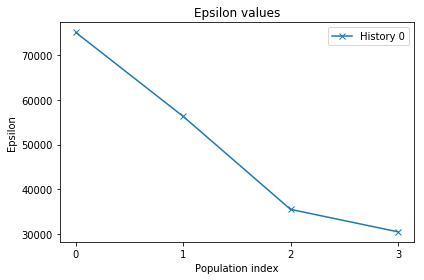

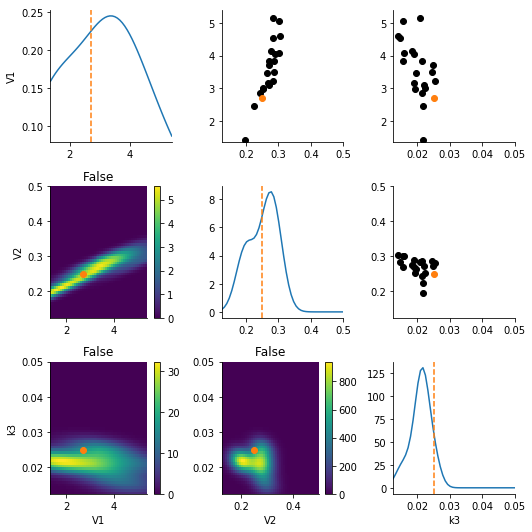

In [8]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()